These experiments were run using two files.

Firstly `continuous.sh` and `train.py`.

Each instance of `train.py` ran a algorithm in a envinronment one time.

To get 10 seeds per environment with 9 envrionments and 3 algorithms there are a total of 270 runs that need to be done.

The 270 runs were completed across two job submissions 1-90 and 91-270.

In [43]:
import os
import numpy as np
import pandas as pd
from itertools import product, chain
import re

# Getting the results

A slight error in the `train.py` code meant that a large chunk of the results had the labels ppo and sac switched, which resulted in the first attempt at the experiments to fail. The result is that the results are split into three different directories from three different grid jobs. Each grid output directory will ony be used to get a single model type from.

In [ ]:
trad_algos = [
    ## First set of basic experiments
    "4676490_rl_continuous_control_baseline_experiments", # 1 million timesteps using SB3 td3 with paper hyperparameters. problem with SAC and PPO mislabeled so we ignore the SAC (which are actually PPO results)
    "4676492_rl_continuous_control_baseline_experiments", # 1 million timesteps using SB3 PPO with paper hyperparameters
    "4676867_rl_continuous_control_baseline_experiments", # 1 million timesteps using SB3 SAC with paper hyperparameters

    # Rerunning some experiments with more timesteps as the final performance was not on par with paper: "Policy ensemble gradient for continuous control problems in deep reinforcement learning" baseline experiments
    "4677137_rl_older_env_benchmarks", # 2 million timesteps on ant environment using SB3 SAC to see if it learns better with more timesteps
    "4677138_rl_older_env_benchmarks", # 2 million timesteps with SB3 TD3 on hopper and swimmer 
    "4677139_rl_older_env_benchmarks", # 2 millions steps with SB3 TD3 on Ant
]

sota_algos = [
    "4677441_tqc_3mil_test", # 3 million time steps using authors original pytorch code and hyperparameters
    "4677444_redq_1mil", # 1 milliion timesteps using authors original pytorch code and hyperparameters
    "4678117_redq_1mil_second_attempt", # Rerunning and GRID engine dropped all the jobs
    "4678116_tqc_3mil_second_attempt" # Rerunning most as the GRID engines had problems with the jobs. A task id mapper was needed as seen below.
]

# The task id is used by the grid engine to run mulitple jobs each with a different experiemnt e.g envs and logs etc.
# Sometime when expriments  fails they need to be rerun but only a somewhat random subset. So a mapper is made to take the given task id (goes from 1 to n) and map it to the task id of the failed experiment.
task_id_mapper = {
    sota_algos[3]:  [
        6, 7, 8, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
        31, 33, 34, 35, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 57, 58, 
        59, 60, 62, 64, 65, 66, 67, 68, 69, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 
        88, 89
    ]
}

grid_output_dir = "/home/thompsjame1/grid-output"
results_dirs = [
    os.path.join(grid_output_dir, d) for d in trad_algos + sota_algos
]

results_dirs

['/home/thompsjame1/grid-output/4676490_rl_continuous_control_baseline_experiments',
 '/home/thompsjame1/grid-output/4676492_rl_continuous_control_baseline_experiments',
 '/home/thompsjame1/grid-output/4676867_rl_continuous_control_baseline_experiments',
 '/home/thompsjame1/grid-output/4677137_rl_older_env_benchmarks',
 '/home/thompsjame1/grid-output/4677138_rl_older_env_benchmarks',
 '/home/thompsjame1/grid-output/4677139_rl_older_env_benchmarks',
 '/home/thompsjame1/grid-output/4677441_tqc_3mil_test',
 '/home/thompsjame1/grid-output/4677444_redq_1mil',
 '/home/thompsjame1/grid-output/4678117_redq_1mil_second_attempt',
 '/home/thompsjame1/grid-output/4678116_tqc_3mil_second_attempt']

In [65]:
def convert_combo_to_number(model, env, seed, total_steps, mapper=None):
    """
    Convert a model, env and seed combindation to the task number that is used fro a grid submission
    """

    models = [
        "tqc",
        "redq",
        "ppo",
        "sac",
        "td3",
    ]

    envs = [
        "HalfCheetah-v5",
        "Walker2d-v5",
        "Humanoid-v5",
        "Ant-v5",
        "HumanoidStandup-v5",
        "Swimmer-v5",
        "Hopper-v5",
        "InvertedDoublePendulum-v5",
        "Pusher-v5",
    ]

    task_id =(0 if models.index(model) < 2 else models.index(model)-2) * 90 + envs.index(env) * 10 + int(seed)

    if mapper is not None:
        task_id = mapper.index(task_id)
    else: 
        task_id = task_id + 1

    return task_id
    
def get_experiment_details(eval_path):
    """
    Take a name of an experiment and get the details from it.
    Assuming the evaluation file is in the format:
    <model>_<env>_<total_steps>_<seed>.npz
    """
    eval_name = eval_path.split('/')[-1]
    model = eval_name.split('_')[0]
    env = eval_name.split('_')[1]
    steps = eval_name.split('_')[2]
    seed = eval_name.split('_')[3].split('.')[0]

    return {
        "model": model,
        "env": env,
        "total_steps": steps,
        "seed": seed
    }
    
def get_details(results_dir):
    """
    Take a results direcrtory and get all the experiment details from it.
    """
    evaluation_files = [os.path.join(results_dir, "training_evaluations", f) for f in os.listdir(os.path.join(results_dir, "training_evaluations"))]

    experiment_details = list(map(get_experiment_details, evaluation_files))

    mapper = task_id_mapper.get(results_dir.split("/")[-1], None)
    task_numbers = list(map(lambda x: convert_combo_to_number(**x, mapper=mapper), experiment_details))

    log_files = [os.path.join(results_dir, "logs", f"{f}_stdout.txt") for f in task_numbers]
    
    experiment_details = [
        {
            "evals": evals,
            "logs": logs,
            "details": details,
        }
        for details, logs, evals in zip(experiment_details, log_files, evaluation_files)
    ]
    return experiment_details

In [66]:
def load_experiments_into_df(result_dirs):
    """
    Load a collection of numpy archive paths into a pandas dataframe.
    It will perform error checking to make sure that all the files are valid and exist as expected.
    It is assumed that the numpy archives have the sample structure with three arrays:
    - 'timesteps': the number of timesteps at evaluations
    - 'results': the rewards at each evaluation
    - 'ep_lengths': the episode lengths at each evaluation
    """
    successful_results, failed_results = [], []

    for experiment in chain.from_iterable(map(get_details, result_dirs)):
        ### Unpacking the evaluation details ###

        try:
            npz = np.load(experiment['evals'])
        except EOFError as e:
            print(f"Failed to load evaluations at {experiment['evals']}: {e}")
            failed_results.append(experiment)
            continue

        evaluation_details = {
            'timesteps': npz['timesteps'],
            'rewards': npz['results'],
            'ep_lengths': npz['ep_lengths'],
            'last_evaluation': npz['timesteps'][-1],
        }

        ### Unpacking the log details ###

        try:
            with open(experiment['logs'], 'r') as f:
                logs = f.readlines()
        except FileNotFoundError as e:
            print(f"Failed to load log at {experiment['logs']}: {e}")
            failed_results.append(experiment)
            continue

        elapsed_seconds = re.search(r"Elapsed seconds: (\d+)", "\n".join(logs))
        if elapsed_seconds is not None:
            elapsed_hours = int(elapsed_seconds.group(1)) / 3600
        else:
            elapsed_hours = None


        ### Adding the details togather ###

        successful_results.append({
            **experiment['details'],
            **evaluation_details,
            "wall_time": elapsed_hours,
        })

    return pd.DataFrame(successful_results), pd.DataFrame(failed_results)

df, failed_df = load_experiments_into_df(results_dirs)
df

Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_3mil_test/training_evaluations/tqc_Swimmer-v5_3000000_0.npz: No data left in file
Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_3mil_test/training_evaluations/tqc_Hopper-v5_3000000_5.npz: No data left in file
Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_3mil_test/training_evaluations/tqc_Humanoid-v5_3000000_9.npz: No data left in file
Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_3mil_test/training_evaluations/tqc_Walker2d-v5_3000000_1.npz: No data left in file
Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_3mil_test/training_evaluations/tqc_Hopper-v5_3000000_6.npz: No data left in file
Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_3mil_test/training_evaluations/tqc_HalfCheetah-v5_3000000_8.npz: No data left in file
Failed to load evaluations at /home/thompsjame1/grid-output/4677441_tqc_

,model,env,total_steps,seed,timesteps,rewards,ep_lengths,last_evaluation,wall_time
0,td3,Pusher-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-48.952695, -53.395769, -50.194313, -52.6373...","[[100, 100, 100, 100, 100, 100, 100, 100, 100,...",1000000,NaN
1,td3,Swimmer-v5,1000000,7,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-21.819346, -18.154842, -8.299162, -13.42011...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000,NaN
2,td3,HumanoidStandup-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[66400.32469, 73734.524948, 60710.972227, 486...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000,NaN
3,sac,Hopper-v5,1000000,3,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[50.358669, 50.412393, 52.065304, 52.538533, ...","[[31, 31, 32, 32, 32, 32, 31, 32, 32, 32], [68...",1000000,NaN
4,sac,Walker2d-v5,1000000,6,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[81.290282, 82.688121, 84.528785, 82.77355, 8...","[[102, 113, 103, 109, 105, 105, 99, 107, 114, ...",1001000,NaN
...,...,...,...,...,...,...,...,...,...
499,tqc,Humanoid-v5,3000000,6,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[92.06776341551326, 91.6687093377923, 92.1125...","[[19, 19, 19, 19, 19, 19, 19, 19, 19, 19], [18...",1743000,NaN
500,tqc,Ant-v5,3000000,1,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[984.1189920517833, 984.2001639143737, 990.86...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",3000000,NaN
501,tqc,Hopper-v5,3000000,2,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[82.6620504860522, 77.96752919585344, 77.4402...","[[54, 51, 51, 52, 51, 55, 52, 53, 52, 52], [34...",347000,NaN
502,tqc,Hopper-v5,3000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[64.41859870498422, 65.70405969595026, 67.748...","[[40, 41, 42, 41, 41, 41, 41, 41, 42, 42], [43...",446000,NaN


In [67]:
# Find duplicate env, algo and seed combos

duplicates = df[df.duplicated(subset=['model', 'env', 'seed'], keep=False)]

# Only keep the ones with the duplicated with the highest total_steps
duplicates = duplicates.sort_values('last_evaluation', ascending=False)
duplicates = duplicates.drop_duplicates(subset=['model', 'env', 'seed'], keep='first')
duplicates

# Drop duplicates from the original dataframe
df = df.sort_values('total_steps', ascending=False).drop_duplicates(subset=['model', 'env', 'seed'], keep='first')
# Reseort by index
df = df.sort_index()
df

,model,env,total_steps,seed,timesteps,rewards,ep_lengths,last_evaluation,wall_time
0,td3,Pusher-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-48.952695, -53.395769, -50.194313, -52.6373...","[[100, 100, 100, 100, 100, 100, 100, 100, 100,...",1000000,NaN
2,td3,HumanoidStandup-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[66400.32469, 73734.524948, 60710.972227, 486...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000,NaN
6,td3,Humanoid-v5,1000000,6,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[106.709213, 106.256858, 100.583666, 100.0033...","[[22, 22, 21, 21, 22, 21, 22, 21, 21, 22], [15...",1000000,NaN
9,td3,HalfCheetah-v5,1000000,5,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-2.036032, -2.527246, -2.147158, -1.283904, ...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000,NaN
12,td3,HumanoidStandup-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[40419.849108, 41418.488874, 37946.688939, 43...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000,NaN
...,...,...,...,...,...,...,...,...,...
499,tqc,Humanoid-v5,3000000,6,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[92.06776341551326, 91.6687093377923, 92.1125...","[[19, 19, 19, 19, 19, 19, 19, 19, 19, 19], [18...",1743000,NaN
500,tqc,Ant-v5,3000000,1,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[984.1189920517833, 984.2001639143737, 990.86...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",3000000,NaN
501,tqc,Hopper-v5,3000000,2,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[82.6620504860522, 77.96752919585344, 77.4402...","[[54, 51, 51, 52, 51, 55, 52, 53, 52, 52], [34...",347000,NaN
502,tqc,Hopper-v5,3000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[64.41859870498422, 65.70405969595026, 67.748...","[[40, 41, 42, 41, 41, 41, 41, 41, 42, 42], [43...",446000,NaN


# Validating the results

I would like to validate two things abotu the results.

1. That the model types are actually waht they say they are.
2. That the correct number of runs and seeds have been run

In [6]:
## Check to see if the amount of runs matches the expected time steps.
df_removed_uncompleted = df[df['total_steps'].astype(int) <= df['last_evaluation']]

df_removed_uncompleted


,model,env,total_steps,seed,timesteps,rewards,ep_lengths,last_evaluation
0,td3,Pusher-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-48.952695, -53.395769, -50.194313, -52.6373...","[[100, 100, 100, 100, 100, 100, 100, 100, 100,...",1000000
2,td3,HumanoidStandup-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[66400.32469, 73734.524948, 60710.972227, 486...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000
6,td3,Humanoid-v5,1000000,6,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[106.709213, 106.256858, 100.583666, 100.0033...","[[22, 22, 21, 21, 22, 21, 22, 21, 21, 22], [15...",1000000
9,td3,HalfCheetah-v5,1000000,5,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-2.036032, -2.527246, -2.147158, -1.283904, ...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000
12,td3,HumanoidStandup-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[40419.849108, 41418.488874, 37946.688939, 43...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",1000000
...,...,...,...,...,...,...,...,...
437,tqc,Ant-v5,3000000,2,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[969.4430804235988, 969.9599344238089, 968.90...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",3000000
468,redq,HumanoidStandup-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[44634.14531868548, 64214.09361104419, 36095....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",1000000
496,tqc,Humanoid-v5,3000000,7,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[122.69938124692591, 122.24132814510324, 116....","[[25, 25, 24, 25, 24, 25, 25, 24, 24, 25], [19...",3000000
500,tqc,Ant-v5,3000000,1,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[984.1189920517833, 984.2001639143737, 990.86...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",3000000


## Make sure that the correct number of experiemnts per model env pair are made

Each environment and model pair needs to be run 10 times. Due to running this on a grid-solar system there is not guarentees that the experiment will complete.

In [9]:
# Count number of seeds per model and env
df_removed_uncompleted.groupby(['model', 'env']).count()

total_steps  seed  timesteps  rewards  \
model env                                                                
ppo   Ant-v5                              10    10         10       10   
      HalfCheetah-v5                      10    10         10       10   
      Hopper-v5                           10    10         10       10   
      Humanoid-v5                         10    10         10       10   
      HumanoidStandup-v5                  10    10         10       10   
      InvertedDoublePendulum-v5           10    10         10       10   
      Pusher-v5                           10    10         10       10   
      Swimmer-v5                          10    10         10       10   
      Walker2d-v5                         10    10         10       10   
redq  HumanoidStandup-v5                   1     1          1        1   
sac   Ant-v5                               9     9          9        9   
      HalfCheetah-v5                      10    10         10       10   
      Hopper-v5                           10    10         10       10   
      Humanoid-v5                         10    10         10       10   
      HumanoidStandup-v5                  10    10         10       10   
      InvertedDoublePendulum-v5           10    10         10       10   
      Pusher-v5                           10    10         10       10   
      Swimmer-v5                          10    10         10       10   
      Walker2d-v5                         10    10         10       10   
td3   Ant-v5                              10    10         10       10   
      HalfCheetah-v5                      10    10         10       10   
      Hopper-v5                           10    10         10       10   
      Humanoid-v5                         10    10         10       10   
      HumanoidStandup-v5                  10    10         10       10   
      InvertedDoublePendulum-v5           10    10         10       10   
      Pusher-v5                           10    10         10       10   
      Swimmer-v5                          10    10         10       10   
      Walker2d-v5                         10    10         10       10   
tqc   Ant-v5                               8     8          8        8   
      HalfCheetah-v5                       7     7          7        7   
      Hopper-v5                            2     2          2        2   
      Humanoid-v5                          1     1          1        1   
      InvertedDoublePendulum-v5            5     5          5        5   
      Pusher-v5                            2     2          2        2   
      Swimmer-v5                           3     3          3        3   
      Walker2d-v5                          2     2          2        2   

                                 ep_lengths  last_evaluation  
model env                                                     
ppo   Ant-v5                             10               10  
      HalfCheetah-v5                     10               10  
      Hopper-v5                          10               10  
      Humanoid-v5                        10               10  
      HumanoidStandup-v5                 10               10  
      InvertedDoublePendulum-v5          10               10  
      Pusher-v5                          10               10  
      Swimmer-v5                         10               10  
      Walker2d-v5                        10               10  
redq  HumanoidStandup-v5                  1                1  
sac   Ant-v5                              9                9  
      HalfCheetah-v5                     10               10  
      Hopper-v5                          10               10  
      Humanoid-v5                        10               10  
      HumanoidStandup-v5                 10               10  
      InvertedDoublePendulum-v5          10               10  
      Pusher-v5                          10               10  
      Swimmer-v5       

In [10]:
def get_missing_runs(df):
    """
    Get the environment model and seed combindations that are missing from the dataframe
    """
    models = df['model'].unique()
    envs = df['env'].unique()
    seeds = df['seed'].unique()

    expected_combinations = list(product(models, envs, seeds))
    print(f"Expected combinations: {expected_combinations}")

    completed_combinations = [tuple(comb) for comb in df[['model', 'env', 'seed']].values.tolist()]
    print(f"Completed combinations: {completed_combinations}")

    missing_combinations = [comb for comb in expected_combinations if comb not in completed_combinations]

    return missing_combinations

missing_combinations = get_missing_runs(df_removed_uncompleted)
len(missing_combinations), missing_combinations

Expected combinations: [('td3', 'Pusher-v5', '8'), ('td3', 'Pusher-v5', '9'), ('td3', 'Pusher-v5', '6'), ('td3', 'Pusher-v5', '5'), ('td3', 'Pusher-v5', '2'), ('td3', 'Pusher-v5', '1'), ('td3', 'Pusher-v5', '0'), ('td3', 'Pusher-v5', '4'), ('td3', 'Pusher-v5', '3'), ('td3', 'Pusher-v5', '7'), ('td3', 'HumanoidStandup-v5', '8'), ('td3', 'HumanoidStandup-v5', '9'), ('td3', 'HumanoidStandup-v5', '6'), ('td3', 'HumanoidStandup-v5', '5'), ('td3', 'HumanoidStandup-v5', '2'), ('td3', 'HumanoidStandup-v5', '1'), ('td3', 'HumanoidStandup-v5', '0'), ('td3', 'HumanoidStandup-v5', '4'), ('td3', 'HumanoidStandup-v5', '3'), ('td3', 'HumanoidStandup-v5', '7'), ('td3', 'Humanoid-v5', '8'), ('td3', 'Humanoid-v5', '9'), ('td3', 'Humanoid-v5', '6'), ('td3', 'Humanoid-v5', '5'), ('td3', 'Humanoid-v5', '2'), ('td3', 'Humanoid-v5', '1'), ('td3', 'Humanoid-v5', '0'), ('td3', 'Humanoid-v5', '4'), ('td3', 'Humanoid-v5', '3'), ('td3', 'Humanoid-v5', '7'), ('td3', 'HalfCheetah-v5', '8'), ('td3', 'HalfCheetah-v5'

(150,
 [('sac', 'Ant-v5', '2'),
  ('tqc', 'Pusher-v5', '8'),
  ('tqc', 'Pusher-v5', '9'),
  ('tqc', 'Pusher-v5', '5'),
  ('tqc', 'Pusher-v5', '2'),
  ('tqc', 'Pusher-v5', '1'),
  ('tqc', 'Pusher-v5', '0'),
  ('tqc', 'Pusher-v5', '4'),
  ('tqc', 'Pusher-v5', '3'),
  ('tqc', 'HumanoidStandup-v5', '8'),
  ('tqc', 'HumanoidStandup-v5', '9'),
  ('tqc', 'HumanoidStandup-v5', '6'),
  ('tqc', 'HumanoidStandup-v5', '5'),
  ('tqc', 'HumanoidStandup-v5', '2'),
  ('tqc', 'HumanoidStandup-v5', '1'),
  ('tqc', 'HumanoidStandup-v5', '0'),
  ('tqc', 'HumanoidStandup-v5', '4'),
  ('tqc', 'HumanoidStandup-v5', '3'),
  ('tqc', 'HumanoidStandup-v5', '7'),
  ('tqc', 'Humanoid-v5', '8'),
  ('tqc', 'Humanoid-v5', '9'),
  ('tqc', 'Humanoid-v5', '6'),
  ('tqc', 'Humanoid-v5', '5'),
  ('tqc', 'Humanoid-v5', '2'),
  ('tqc', 'Humanoid-v5', '1'),
  ('tqc', 'Humanoid-v5', '0'),
  ('tqc', 'Humanoid-v5', '4'),
  ('tqc', 'Humanoid-v5', '3'),
  ('tqc', 'HalfCheetah-v5', '8'),
  ('tqc', 'HalfCheetah-v5', '6'),
  ('tqc',

In [11]:

missing_nums = [convert_combo_to_number(combo) for combo in missing_combinations]
missing_nums.sort()
missing_nums

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 6,
 7,
 7,
 8,
 8,
 9,
 10,
 10,
 11,
 11,
 12,
 12,
 13,
 14,
 14,
 15,
 16,
 16,
 17,
 17,
 18,
 18,
 19,
 19,
 20,
 20,
 21,
 21,
 22,
 22,
 23,
 23,
 24,
 24,
 25,
 25,
 26,
 26,
 27,
 28,
 28,
 29,
 29,
 30,
 31,
 32,
 33,
 34,
 34,
 35,
 35,
 36,
 37,
 38,
 39,
 40,
 40,
 41,
 41,
 42,
 42,
 43,
 43,
 44,
 44,
 45,
 45,
 46,
 46,
 47,
 47,
 48,
 49,
 49,
 50,
 50,
 51,
 51,
 52,
 53,
 53,
 54,
 54,
 55,
 56,
 57,
 57,
 58,
 58,
 59,
 59,
 60,
 60,
 61,
 62,
 62,
 63,
 64,
 64,
 65,
 65,
 66,
 66,
 67,
 67,
 68,
 68,
 69,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 75,
 76,
 76,
 77,
 77,
 78,
 78,
 79,
 79,
 80,
 80,
 81,
 81,
 82,
 82,
 83,
 83,
 84,
 84,
 85,
 85,
 86,
 87,
 88,
 88,
 89,
 89,
 122]

# Visualizing the results

## Learning curves

In [79]:
df_grouped = df.explode(['timesteps', 'rewards']).groupby(['model', 'env', 'timesteps']).agg({
    "rewards": lambda x: np.vstack(x),
}).reset_index()
df_grouped

,model,env,timesteps,rewards
0,ppo,Ant-v5,1000,"[[994.002296, 992.628523, 995.069539, 988.2331..."
1,ppo,Ant-v5,2000,"[[997.553241, 996.017129, 998.635264, 994.9632..."
2,ppo,Ant-v5,3000,"[[987.076178, 987.289457, 987.211626, 988.9279..."
3,ppo,Ant-v5,4000,"[[990.587657, 990.176489, 985.988487, 989.6232..."
4,ppo,Ant-v5,5000,"[[978.307347, 985.207296, 982.196496, 979.1563..."
...,...,...,...,...
61040,tqc,Walker2d-v5,2996000,"[[6469.95084545808, 6558.950047949435, 6413.62..."
61041,tqc,Walker2d-v5,2997000,"[[358.92436463660925, 6525.366503172048, 6547...."
61042,tqc,Walker2d-v5,2998000,"[[6469.128324953206, 6473.970026518167, 6472.4..."
61043,tqc,Walker2d-v5,2999000,"[[6464.3824404794805, 6441.599181737605, 339.7..."


In [82]:
def add_mean_ci(df, ci, axis=None): 
    df["mean_rewards"] = df["rewards"].apply(lambda x: np.mean(x, axis=axis))
    ci = 85
    df['upper_ci'] = df['rewards'].apply(lambda x: np.percentile(x, ci, axis=axis))
    df['lower_ci'] = df['rewards'].apply(lambda x: np.percentile(x, 100-ci, axis=axis))
    return df

df_grouped = add_mean_ci(df_grouped, 85)

df_grouped

,model,env,timesteps,rewards,mean_rewards,upper_ci,lower_ci
0,ppo,Ant-v5,1000,"[[994.002296, 992.628523, 995.069539, 988.2331...",993.814065,997.161469,989.187537
1,ppo,Ant-v5,2000,"[[997.553241, 996.017129, 998.635264, 994.9632...",994.207132,998.331642,989.682483
2,ppo,Ant-v5,3000,"[[987.076178, 987.289457, 987.211626, 988.9279...",987.942770,992.277269,981.427154
3,ppo,Ant-v5,4000,"[[990.587657, 990.176489, 985.988487, 989.6232...",988.130807,993.087112,982.276771
4,ppo,Ant-v5,5000,"[[978.307347, 985.207296, 982.196496, 979.1563...",984.505891,994.996968,977.830133
...,...,...,...,...,...,...,...
61040,tqc,Walker2d-v5,2996000,"[[6469.95084545808, 6558.950047949435, 6413.62...",6364.924786,6505.845613,6265.177991
61041,tqc,Walker2d-v5,2997000,"[[358.92436463660925, 6525.366503172048, 6547....",6015.685852,6530.118806,6101.314506
61042,tqc,Walker2d-v5,2998000,"[[6469.128324953206, 6473.970026518167, 6472.4...",6375.360324,6540.438827,6253.653870
61043,tqc,Walker2d-v5,2999000,"[[6464.3824404794805, 6441.599181737605, 339.7...",4501.522563,6426.978036,371.369438


In [14]:
from scipy.signal import savgol_filter

# Add a smoothing function using Savitzky-Golay
def smooth_savgol(data, window_size=50, polyorder=2):
    # Ensure the window size is smaller than the data length
    if len(data) < window_size:
        window_size = len(data) if len(data) % 2 == 1 else len(data) - 1  # Ensure window size is odd
    return savgol_filter(data, window_size, polyorder)

# Apply smoothing to each group
def apply_smoothing(group):
    group = group.sort_values("timesteps")  # Ensure data is sorted by x-axis (env_steps)
    group["smoothed_mean_rewards"] = smooth_savgol(group["mean_rewards"])
    group["smoothed_upper_ci"] = smooth_savgol(group["upper_ci"])
    group["smoothed_lower_ci"] = smooth_savgol(group["lower_ci"])
    return group

# Group by model, algo, and env, and apply smoothing
df_smoothed = df_grouped.groupby(["model", "env"]).apply(apply_smoothing)

df_smoothed

/tmp/ipykernel_1419545/758811617.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df_grouped.groupby(["model", "env"]).apply(apply_smoothing)


model          env  timesteps  \
model env                                               
ppo   Ant-v5      0       ppo       Ant-v5       1000   
                  1       ppo       Ant-v5       2000   
                  2       ppo       Ant-v5       3000   
                  3       ppo       Ant-v5       4000   
                  4       ppo       Ant-v5       5000   
...                       ...          ...        ...   
tqc   Walker2d-v5 60920   tqc  Walker2d-v5    2996000   
                  60921   tqc  Walker2d-v5    2997000   
                  60922   tqc  Walker2d-v5    2998000   
                  60923   tqc  Walker2d-v5    2999000   
                  60924   tqc  Walker2d-v5    3000000   

                                                                   rewards  \
model env                                                                    
ppo   Ant-v5      0      [[994.002296, 992.628523, 995.069539, 988.2331...   
                  1      [[997.553241, 996.017129, 998.635264, 994.9632...   
                  2      [[987.076178, 987.289457, 987.211626, 988.9279...   
                  3      [[990.587657, 990.176489, 985.988487, 989.6232...   
                  4      [[978.307347, 985.207296, 982.196496, 979.1563...   
...                                                                    ...   
tqc   Walker2d-v5 60920  [[6469.95084545808, 6558.950047949435, 6413.62...   
                  60921  [[358.92436463660925, 6525.366503172048, 6547....   
                  60922  [[6469.128324953206, 6473.970026518167, 6472.4...   
                  60923  [[6464.3824404794805, 6441.599181737605, 339.7...   
                  60924  [[6491.661589476861, 6531.004099275907, 6492.8...   

                         mean_rewards  max_rewards  min_rewards     upper_ci  \
model env                                                                      
ppo   Ant-v5      0        993.814065  1004.952310   985.528747   997.161469   
                  1        994.207132  1003.606960   984.486736   998.331642   
                  2        987.942770  1006.239413   965.776645   992.277269   
                  3        988.130807  1004.213439   958.616273   993.087112   
                  4        984.505891  1014.399710   964.516934   994.996968   
...                               ...          ...          ...          ...   
tqc   Walker2d-v5 60920   6364.924786  6558.950048  6218.065395  6505.845613   
                  60921   6015.685852  6577.175458   358.924365  6530.118806   
                  60922   6375.360324  6551.855262  6110.079692  6540.438827   
                  60923   4501.522563  6464.382440   261.541211  6426.978036   
                  60924   5754.983880  6531.004099   330.193717  6493.972275   

                            lower_ci  smoothed_mean_rewards  \
model env                                                     
ppo   Ant-v5      0       989.187537            1010.429734   
                  1       989.682483            1006.300652   
                  2       981.427154            1001.858263   
                  3       982.276771             997.102567   
                  4       977.830133             992.033563   
...                              ...                    ...   
tqc   Walker2d-v5 60920  6265.177991            5698.435814   
                  60921  6101.314506            5667.560295   
                  60922  6253.653870            5635.719600   
                  60923   371.369438            5602.913729   
                  60924  6222.940525            5569.142681   

                         smoothed_upper_ci  smoothed_lower_ci  
model env                                                      
ppo   Ant-v5      0            1008.400956        1080.269027  
                  1            1006.733763        1064.641876  
                  2            1004.992203        1048.666713  
                  3            1003.176275        1032.343538  
                  4   

In [15]:
models = df['model'].unique()
envs = df['env'].unique()
seeds = df['seed'].unique()

In [16]:
final_environments = [
    "Humanoid",
    "HumanoidStandup",
    "Walker2d",
    "Ant",
    "HalfCheetah",
    "Hopper",
]
final_environments = list(map(lambda x: f"{x}-v5", final_environments))

final_environments

['Humanoid-v5',
 'HumanoidStandup-v5',
 'Walker2d-v5',
 'Ant-v5',
 'HalfCheetah-v5',
 'Hopper-v5']

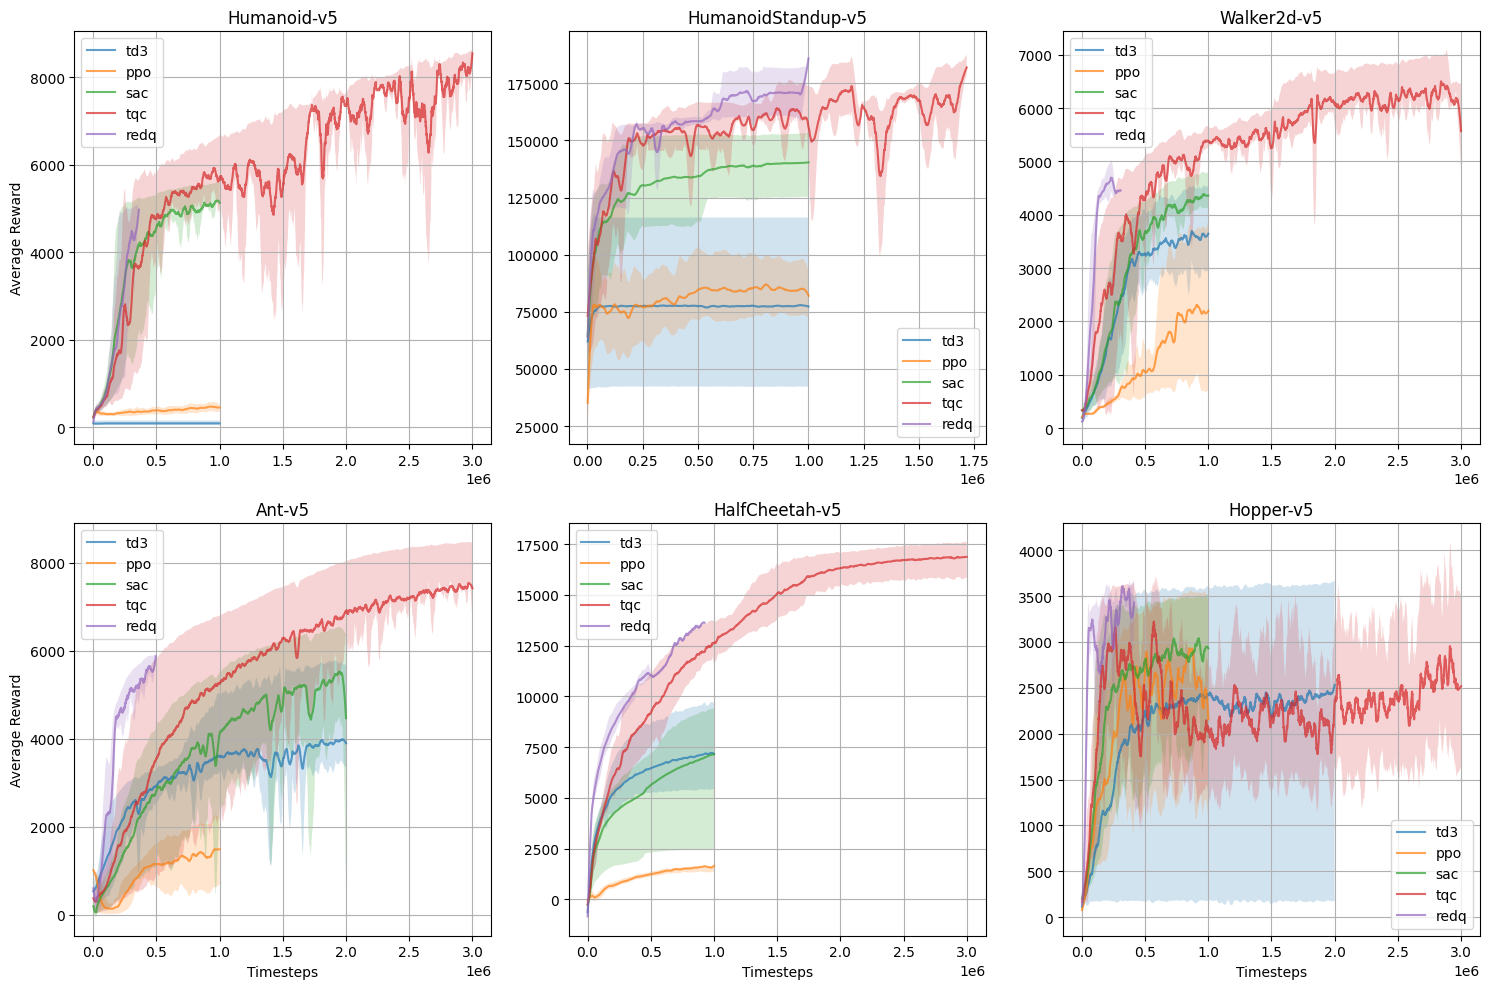

In [17]:
import matplotlib.pyplot as plt

def plot(df, envs):
    rows = 2  # Number of rows in the grid
    cols = 3  # Number of columns in the grid
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

    for i, env in enumerate(envs):
        ax = axes[i]
        for model in models:
            df_plot = df[(df['model'] == model) & (df['env'] == env)]
            if df_plot.empty:
                continue
            
            # Plot the mean rewards as a line
            ax.plot(df_plot['timesteps'], df_plot['smoothed_mean_rewards'], label=model, alpha=0.7)
            
            # Fill between the min and max rewards to create the shaded area
            ax.fill_between(
                df_plot['timesteps'],
                df_plot["smoothed_upper_ci"],
                df_plot["smoothed_lower_ci"],
                alpha=0.2
            )
        
        ax.set_title(f'{env}')
        if i % cols == 0:  # Only show y-axis label on the first column
            ax.set_ylabel('Average Reward')
        if i >= (rows - 1) * cols:  # Only show x-axis label on the last row
            ax.set_xlabel('Timesteps')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
    return fig

plot(df_smoothed, final_environments).savefig("../figures/baseline_results.png", dpi=300, bbox_inches='tight')

### Comparing to PEG paper results

For these becnhmarks it is important that we get similar results to other papers.

In [22]:
PEG = {
    "td3": {
        "hopper": 3200,
        "swimmer": 57,
        "walker2d": 3700,
        "humanoid": 200,
        "ant": 4300,
        "humanoidstandup": 82000
    },
    "sac": {
        "hopper": 3200,
        "swimmer": 42,
        "walker2d": 4500,
        "humanoid": 5200,
        "ant": 5200,
        "humanoidstandup": 140000
    }
}

mine = {
    "td3": {
        "halfcheetah": 7000,
        "walker2d": 3500,
        "humanoid": 200,
        "ant": 3000,
        "humanoidstandup": 80000,
        "swimmer": 48,
        "hopper": 2600,
        "inverteddoublependulum": 8200,
        "pusher": -50
    },
    "sac": {
        "halfcheetah": 7000,
        "walker2d": 4500,
        "humanoid": 5000,
        "ant": 4200,
        "humanoidstandup": 140000,
        "swimmer": 80,
        "hopper": 3000,
        "inverteddoublependulum": 8200,
        "pusher": -30
    },
    "ppo": {
        "halfcheetah": 1800,
        "walker2d": 2100,
        "humanoid": 500,
        "ant": 1800,
        "humanoidstandup": 82500,
        "swimmer": 110,
        "hopper": 2500,
        "inverteddoublependulum": 600,
        "pusher": -30
    }
}



In [23]:
percentage_threshold = 10  # Adjust this value as needed (e.g., 20% difference)
def compare_results_with_percentage(other, mine, percentage_threshold):
    significant_differences = {}
    
    for algo in other:
        if algo in mine:
            for env, peg_value in other[algo].items():
                if env in mine[algo]:
                    mine_value = mine[algo][env]
                    if peg_value != 0:  # Avoid division by zero
                        percentage_diff = (peg_value - mine_value) / abs(peg_value) * 100
                        if percentage_diff > percentage_threshold:
                            if algo not in significant_differences:
                                significant_differences[algo] = {}
                            significant_differences[algo][env] = {
                                "PEG": peg_value,
                                "mine": mine_value,
                                "percentage_difference": percentage_diff
                            }
    return significant_differences

# Compare PEG and mine
significant_differences = compare_results_with_percentage(PEG, mine, percentage_threshold)

# Print the results
for algo, envs in significant_differences.items():
    print(f"Algorithm: {algo}")
    for env, values in envs.items():
        print(f"  Environment: {env}")
        print(f"    PEG paper Value: {values['PEG']}")
        print(f"    My hyperparameter Value: {values['mine']}")
        print(f"    Percentage Difference: {values['percentage_difference']:.2f}%")

Algorithm: td3
  Environment: hopper
    PEG paper Value: 3200
    My hyperparameter Value: 2600
    Percentage Difference: 18.75%
  Environment: swimmer
    PEG paper Value: 57
    My hyperparameter Value: 48
    Percentage Difference: 15.79%
  Environment: ant
    PEG paper Value: 4300
    My hyperparameter Value: 3000
    Percentage Difference: 30.23%
Algorithm: sac
  Environment: ant
    PEG paper Value: 5200
    My hyperparameter Value: 4200
    Percentage Difference: 19.23%


## Wall clock time

In [105]:
test = df.explode(['timesteps', 'rewards']).groupby(['model', 'env', 'timesteps']).agg({
    "rewards": lambda x: np.vstack(x),
    "wall_time": lambda x: np.mean(x),
}).reset_index()
test.dropna(subset=['wall_time'], inplace=True)
test

,model,env,timesteps,rewards,wall_time
11271,redq,HumanoidStandup-v5,1000,"[[50956.823714286475, 59421.505687543, 80315.0...",33.048889
11272,redq,HumanoidStandup-v5,2000,"[[68418.4444249729, 73560.34930845832, 87084.8...",33.048889
11273,redq,HumanoidStandup-v5,3000,"[[81479.27674055385, 85256.75494089205, 91667....",33.048889
11274,redq,HumanoidStandup-v5,4000,"[[71295.2904903299, 91112.95845718781, 95840.8...",33.048889
11275,redq,HumanoidStandup-v5,5000,"[[85754.03302343316, 73357.03540987853, 75228....",33.048889
...,...,...,...,...,...
49040,tqc,HumanoidStandup-v5,1712000,"[[183460.63515569543, 180526.1552402534, 18418...",19.495000
49041,tqc,HumanoidStandup-v5,1713000,"[[184636.42100060667, 177262.82361351035, 1900...",19.495000
49042,tqc,HumanoidStandup-v5,1714000,"[[184038.9412634298, 181836.85495217604, 18106...",19.495000
49043,tqc,HumanoidStandup-v5,1715000,"[[186671.3096076913, 182666.09258021927, 18933...",19.495000


In [161]:
def cut_to_length(df, length=1_000_000):
    """
    Cut the dataframe experiemtns data to length
    """
    df = df.copy().dropna(subset=['wall_time'])

    num_evals = length // 1_000

    df['timesteps'] = df['timesteps'].apply(lambda x: x[x <= length])
    df['rewards'] = df['rewards'].apply(lambda x: x[:num_evals])
    df['ep_lengths'] = df['ep_lengths'].apply(lambda x: x[:num_evals])

    df['time_to_length'] = df['wall_time'] / df['last_evaluation'] * length
    df['wall_time_approx_steps'] = df['time_to_length'].apply(lambda x: np.linspace(0, x, num_evals))
    df.drop("last_evaluation", axis=1, inplace=True)

    return df

wall_clock_measurements = cut_to_length(df)
wall_clock_measurements

,model,env,total_steps,seed,timesteps,rewards,ep_lengths,wall_time,time_to_length,wall_time_approx_steps
465,redq,HumanoidStandup-v5,1000000,7,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[93169.64751455454, 96963.02440865105, 77384....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",41.095000,41.095000,"[0.0, 0.041136136136136134, 0.0822722722722722..."
468,redq,HumanoidStandup-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[44634.14531868548, 64214.09361104419, 36095....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",25.002778,25.002778,"[0.0, 0.025027805583361137, 0.0500556111667222..."
492,tqc,HumanoidStandup-v5,3000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[29633.347438283527, 30088.37564894468, 29905...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",19.495000,11.360723,"[0.0, 0.01137209470542804, 0.02274418941085608..."
498,tqc,HumanoidStandup-v5,3000000,4,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[31479.434579709712, 31549.749139476215, 3143...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",21.404444,19.458586,"[0.0, 0.01947806392250837, 0.03895612784501674..."
503,tqc,Ant-v5,3000000,3,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[976.3833487806032, 968.6006281058587, 972.78...","[[1000, 1000, 1000, 1000, 1000, 1000, 1000, 10...",14.840000,4.946667,"[0.0, 0.004951618284951619, 0.0099032365699032..."


In [162]:
merged_wall_clock_measurements = wall_clock_measurements.groupby(["model", "env"]).agg({
    'rewards': lambda x: np.hstack(x),
    'time_to_length': lambda x: np.mean(x),
    'wall_time_approx_steps': lambda x: x.iloc[0],
}).reset_index()

merged_wall_clock_measurements

,model,env,rewards,time_to_length,wall_time_approx_steps
0,redq,HumanoidStandup-v5,"[[93169.64751455454, 96963.02440865105, 77384....",33.048889,"[0.0, 0.041136136136136134, 0.0822722722722722..."
1,tqc,Ant-v5,"[[976.3833487806032, 968.6006281058587, 972.78...",4.946667,"[0.0, 0.004951618284951619, 0.0099032365699032..."
2,tqc,HumanoidStandup-v5,"[[29633.347438283527, 30088.37564894468, 29905...",15.409654,"[0.0, 0.01137209470542804, 0.02274418941085608..."


In [163]:
merged_wall_clock_measurements = add_mean_ci(merged_wall_clock_measurements, 85, 1)
merged_wall_clock_measurements

,model,env,rewards,time_to_length,wall_time_approx_steps,mean_rewards,upper_ci,lower_ci
0,redq,HumanoidStandup-v5,"[[93169.64751455454, 96963.02440865105, 77384....",33.048889,"[0.0, 0.041136136136136134, 0.0822722722722722...","[67887.55274175963, 64433.288915774334, 66969....","[96355.29242871086, 97542.78636811218, 98307.5...","[43382.153329504734, 36399.04708880266, 39202...."
1,tqc,Ant-v5,"[[976.3833487806032, 968.6006281058587, 972.78...",4.946667,"[0.0, 0.004951618284951619, 0.0099032365699032...","[971.9597988277877, 729.574571457739, 465.2572...","[975.1530368020842, 754.6103920604149, 574.924...","[968.972458816535, 707.7967641633601, 369.6960..."
2,tqc,HumanoidStandup-v5,"[[29633.347438283527, 30088.37564894468, 29905...",15.409654,"[0.0, 0.01137209470542804, 0.02274418941085608...","[30619.62492463955, 82588.92572791164, 70664.0...","[31554.3270045627, 93858.39989644114, 106970.7...","[29613.936133202442, 71783.24820423144, 47331...."


model                                                                  redq
env                                                      HumanoidStandup-v5
rewards                   [[93169.64751455454, 96963.02440865105, 77384....
time_to_length                                                    33.048889
wall_time_approx_steps    [0.0, 0.041136136136136134, 0.0822722722722722...
mean_rewards              [67887.55274175963, 64433.288915774334, 66969....
upper_ci                  [96355.29242871086, 97542.78636811218, 98307.5...
lower_ci                  [43382.153329504734, 36399.04708880266, 39202....
Name: 0, dtype: object
model                                                                   tqc
env                                                      HumanoidStandup-v5
rewards                   [[29633.347438283527, 30088.37564894468, 29905...
time_to_length                                                    15.409654
wall_time_approx_steps    [0.0, 0.01137209470542804, 0.0227441894

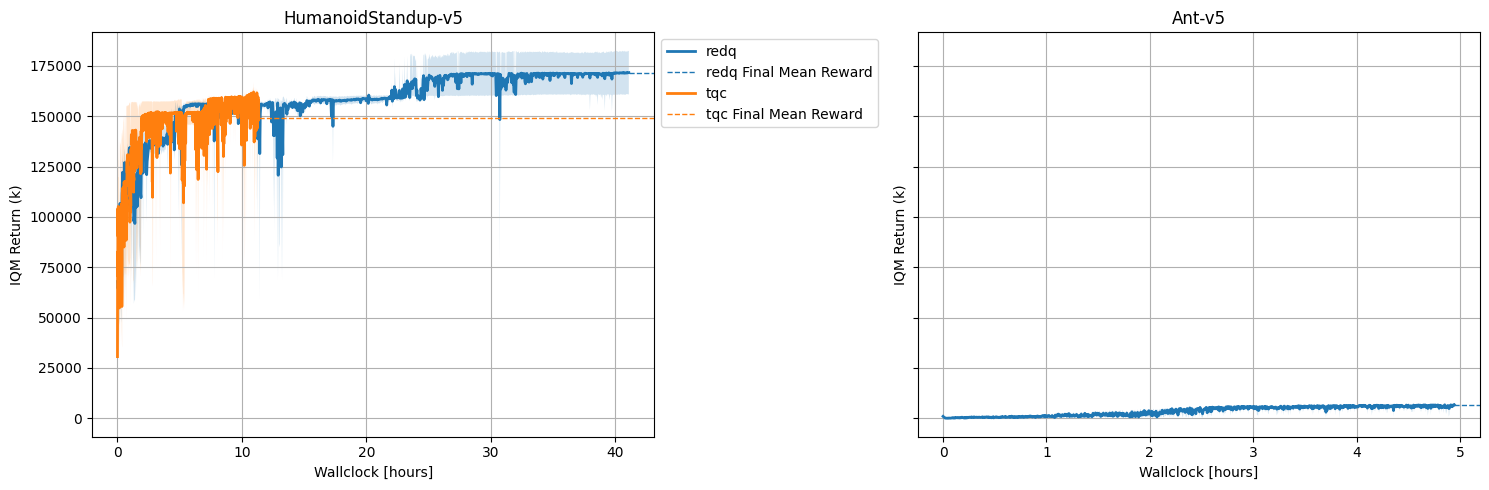

In [172]:
import matplotlib.pyplot as plt

def make_wall_time_plot(data):
    # Get unique environments
    envs = data["env"].unique()
    num_envs = len(envs)

    # Create subplots
    fig, axes = plt.subplots(1, num_envs, figsize=(15, 5), sharey=True)
    if num_envs == 1:
        axes = [axes]  # Ensure axes is iterable for a single subplot

    for ax, env in zip(axes, envs):
        # Filter data for the current environment
        env_data = data[data["env"] == env]

        # Plot mean rewards
        for model in env_data["model"].unique():
            model_data = env_data[env_data["model"] == model].iloc[0]
            print(model_data)
            line,  =ax.plot(
                model_data["wall_time_approx_steps"],
                [0] + model_data["mean_rewards"],
                label=model,
                linewidth=2,
            )

            # Plot confidence intervals
            ax.fill_between(
                model_data["wall_time_approx_steps"],
                [0] + model_data["lower_ci"],
                [0] + model_data["upper_ci"],
                alpha=0.2,
            )

            # Add a horizontal bar at the height of the final mean reward
            final_mean_reward = model_data["mean_rewards"][-1]
            final_wall_clock = model_data["wall_time_approx_steps"][-1]
            
            final_wall_clock_axes = ax.transData.transform((final_wall_clock, 0))[0]  # Transform to display coordinates
            final_wall_clock_axes = ax.transAxes.inverted().transform((final_wall_clock_axes, 0))[0]  # Transform 
            ax.axhline(
                xmin=final_wall_clock_axes,
                y=final_mean_reward,
                color=line.get_color(),
                linestyle="--",
                linewidth=1,
                label=f"{model} Final Mean Reward",
            )


        # Set titles and labels
        ax.set_title(env)
        ax.set_xlabel("Wallclock [hours]")
        ax.set_ylabel("IQM Return (k)")
        ax.grid(True)

    # Add legend
    axes[0].legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
make_wall_time_plot(merged_wall_clock_measurements)